# Whiteaway case opgave Juni 2021

Data:

* https://www.kaggle.com/carrie1/ecommerce-data




## Overview

1. Begrænsninger ved dette datasæt.

2. Basic stats og exploration.

3. Recommendation systems:

     1. Non-personalized input: Product page view, eller Indkøbskurv.
     2. Personalized input: User purchase history.

3. Primitiv produkt-popularitets anbefalings model.

4. Graf-baserede modeller (produkt-orienteret; for et enkelt produkt, eller en indkøbskurv med flere produkter).

     1. Model baseret på "hvad blev købt sammen" (i samme ordre).
     2. Model baseret på "kunder som tidligere har købt X er mere tilbøjelige til at købe Y".

5. Personaliseret model, baseret på hvad lignende kunder tidligere har købt.

     1. Her går vi ind og ser på hvilke andre kunder en kunde ligner, og anbefaler ud fra det.

6. Anden-ordens effekter:

     1. Negativ respons

7. Standard Recommendation systemer:

     1. Collaborative filtering.
     2. Content-based recommendations.

8. Efterbehandling af anbefalinger

     1. Hvis en kunde fx allerede har købt en støvsuger, så køber han nok ikke en mere.

8. Evaluering og kvantificering af modeller.

     1. Evaluering baseret på opdeling af eksisterende salgs datasæt i to dele. Første bruges til at lave model, anden del til at evaluere. *Dette er ikke optimalt,* men det bedste vi kan gøre med bare ét statisk datasæt.

9. Fuldt system: Kombinering af anbefalinger fra forskellige recommenders

    1. Vi har mulighed for at lave mange forskellige recommender systemer. 
       Hvordan kombinerer vi dem bedst, så vi får et optimalt output?

10. Diskussion



## Begrænsninger ved dette datasæt

(Og modeller baseret primært på dette dataset)

***Retrospektivt:***

* Beskriver hvilke produkter kunder har købt sammen.
* Hvis kunde A har købt produkt X, hvilke produkter har kunde A købt sammen med X eller efterfølgende?

* Reflekterer hvilke påvirkninger kunderne tidligere har været udsat for -> Bias.

* Vi er ofte mere interesseret i: Hvis kunde A lægger produkt X i sin indkøbsvogn, hvilke produktanbefalinger resulterer så i mest mersalg?

* Fx: Kunder der har købt en Dyson støvsuger har også købt Dyson-branded tilbehør.
* Resultat: Den retrospektive model fremhæver produktanbefalinger for Dyson-branded tilbehør.


***Positivt feedback loop***:

* Kunde A har købt/kurvet produkt X.
  * -> Model anbefaler produkt Y til kunde A
  * -> Kunde A køber produkt Y
  * -> Modellen forstærkes i at anbefale produkt Y til kunder som har købt/kurvet produkt X. 

* Det er vigtigt at måle *effekten* af produktanbefalinger:
* *Hvis* kunde A vises en produktanbefaling for produkt Y, hvor sandsynligt er det så at kunde A køber produkt Y


**Fokus på salg af *tilbehør*:**

* Kunder som køber en Dyson støvsuger er tilbøjelige til at købe tilbehør til støvsugeren sammen eller efterfølgende. Så den retrospektive model anbefaler Dyson-tilbehør til kunden (og det er fint - bekvemt for kunden).

* Men det er også vigtigt at have en anden model som kan anbefale mere end bare tilbehør.
* Kan til dels afhjælpes ved at inkludere produktpriser, men det kan marginalisere billigt tilbehør som ellers ville øge kundetilfredsheden -> vigtigt at have begge typer anbefalinger.

* Hvis vi fx anbefaler en robotstøvsuger, så er det måske ikke helt så effektivt "per anbefaling", men i de tilfælde hvor det virker, så ender vi med betydeligt mere mersalg i forhold til bare at anbefale tilbehør, som kunden måske allerede havde besluttet sig for at købe.


**Ikke nogen *produktkategorier*:**

* Datasættet har ikke nogen "kategorier", som ellers vil gøre det nemmere at filtrere.
* Fx, hvis modellen anbefaler en kunde at købe produkt Y, men kunden tidligere har købt et tilsvarende produkt til Y men fx et andet mærke eller model, så vil kunden   
* Det bliver med tiden reflekteret i modellen (negative inputs), men det tager lang tid hvis modellen skal finde det negative input for hvert tilsvarende produkt i samme kategori. Det er hurtigere hvis modellen kan sige "kunde A har allerede købt en blender, så lad være med at anbefale nogen blendere overhovedet (men du kan stadig anbefale *tilbehør* til den blender han har købt)." 


***Konservativt:***

* Tager lang tid om at ændre sig, fordi den er baseret på historiske salg.
* Kan afhjælpes ved at have modeller som kigger på kortere tid (seneste uge/måned) -> men det giver mindre datagrundlag så større usikkerhed.
* Igen, det er bedre med modeller, som måler **effekten** af konkrete produktanbefalinger til en given type kunde.


Det leder mig til en anden begrænsning ved dette dataset: 



## Yderligere data ønsket

Indsamling af data (for hver kunde session) udover kun selve *salget*:

* Sidevisninger.
* Navigation.
* Søgninger.
* Referencer fra mails og eksterne sider.
* Produktanbefalinger. Hvilke produkter får kunden anbefalet.
* Manuelle produktanbefalinger/reklamer vs automatiske.
* Indkøbskurv (tilføjelser, fjernelser).




## Disclaimer:

Jeg har selv lavet det meste af dette arbejde "fra grunden".

Normalt vil jeg starte med at kigge på eksisterende pakker og litteratur når jeg skal løse et problem, og modificere og bygge op fra det, og først til sidst starte "from scratch" med mine egne idéer.



In [1]:
import pandas as pd

from collections import defaultdict
import timeit
import itertools
import random
import matplotlib
from matplotlib import pyplot
from pprint import pprint

In [2]:
# Notebook configuratio: Automatic display of plots, etc


In [3]:
# Download data:
# Requires kaggle login
# Download manually from https://www.kaggle.com/carrie1/ecommerce-data

# Download with Kaggle API and python package
# Auth in environment vars:
#   export KAGGLE_USERNAME=datadinosaur
#   export KAGGLE_KEY=xxxxxxxxxxxxxx
# Auth in kaggle.json file: 
# Download kaggle.json from account page on kaggle.com and place in ~/.kaggle/kaggle.json
# pip install kaggle

# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files(
#     'The_name_of_the_dataset', 
#     path='data/raw', 
#     unzip=True
# )

In [36]:
# Load data
df = df_raw = pd.read_csv("../data/raw/data.csv", keep_default_na=False)
print(f"Table rows:", len(df))
df.head()

Table rows: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [37]:
# Remove bad data:
df = df_raw
print("Rows before QA filtering:", len(df))

# Remove lines with N/A values:
for column in df.columns:
    print(f" - NaN {column}:", df[column].isna().sum()) 
df = df_dropna = df.dropna()
print("Rows after dropping N/A:", len(df))

print("Columns with empty values:")
for column in df.columns:
    print(f" - {column} empty values:", (df[column] == '').sum()) 
    df = df[~(df[column] == '')]
print("Rows after dropping rows with empty values:", len(df))

# Remove lines that does not represent an actual product:
print("Non-product stock codes:")
non_product_stock_codes = ['BANK CHARGES', 'C2', 'CRUK', 'D', 'DOT', 'M', 'PADS', 'POST']
for code in non_product_stock_codes:
    print(f" - {code} lines:", (df['StockCode'] == code).sum()) 
df = df[~df['StockCode'].isin(['BANK CHARGES', 'C2', 'CRUK', 'D', 'DOT', 'M', 'PADS', 'POST'])]
print("Rows after dropping non-product lines:", len(df))

print("Rows after QA filtering:", len(df))


Rows before QA filtering: 541909
 - NaN InvoiceNo: 0
 - NaN StockCode: 0
 - NaN Description: 0
 - NaN Quantity: 0
 - NaN InvoiceDate: 0
 - NaN UnitPrice: 0
 - NaN CustomerID: 0
 - NaN Country: 0
Rows after dropping N/A: 541909
Columns with empty values:
 - InvoiceNo empty values: 0
 - StockCode empty values: 0
 - Description empty values: 1454
 - Quantity empty values: 0
 - InvoiceDate empty values: 0
 - UnitPrice empty values: 0
 - CustomerID empty values: 133626
 - Country empty values: 0
Rows after dropping rows with empty values: 406829
Non-product stock codes:
 - BANK CHARGES lines: 12
 - C2 lines: 134
 - CRUK lines: 16
 - D lines: 77
 - DOT lines: 16
 - M lines: 465
 - PADS lines: 4
 - POST lines: 1196
Rows after dropping non-product lines: 404909
Rows after QA filtering: 404909


In [6]:
# Reduce table size for dev/testing:
# df_fullsize = df
# df = df[:20000]
# print("Rows after reducing table size for testing:", len(df))

# Basic stats:

Histograms and bar charts:

* Items per order.
* Orders per item.
* Orders per customer.
* Time since customer's last order.
* Units sold for each product (total, last year, last quarter).

Graphs:

* Customer base over time?
* Purchases over time?
* Product price vs units sold.
* Etc.

Other:
* How many returns (negative qty) as percentage.


### Basic stats 1: Items per order

* Spørgsmål: Hvad er det hyppigste antal produkter per ordre?

* Spørgsmål: Hvor stort er potentialet for mer-salg?
    * Hvis det hyppigste antal produkter per ordre er meget lavt, så er der et stort potentiale for mer-salg.


Items on invoice with most unique items: 541


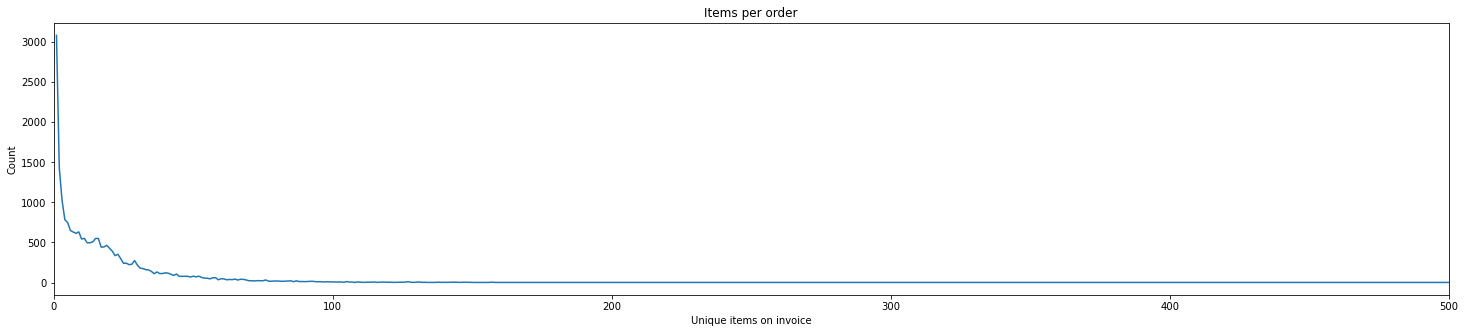

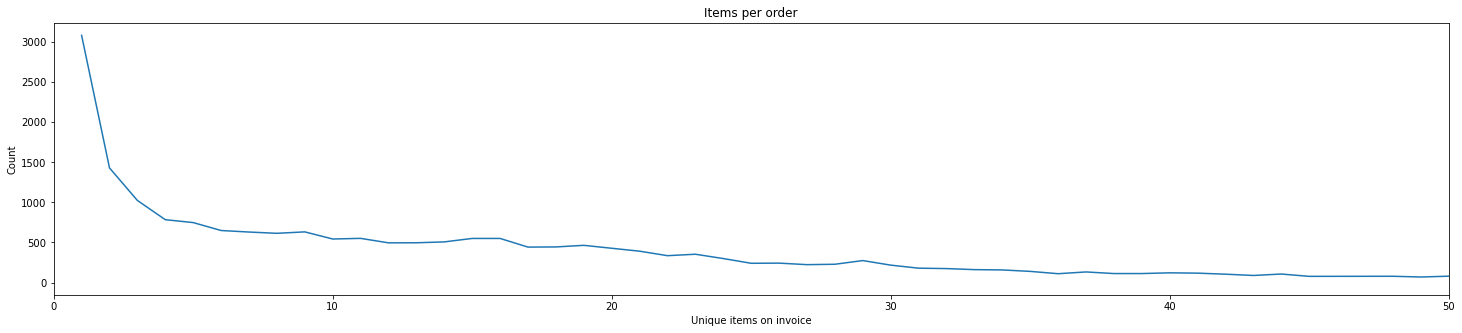

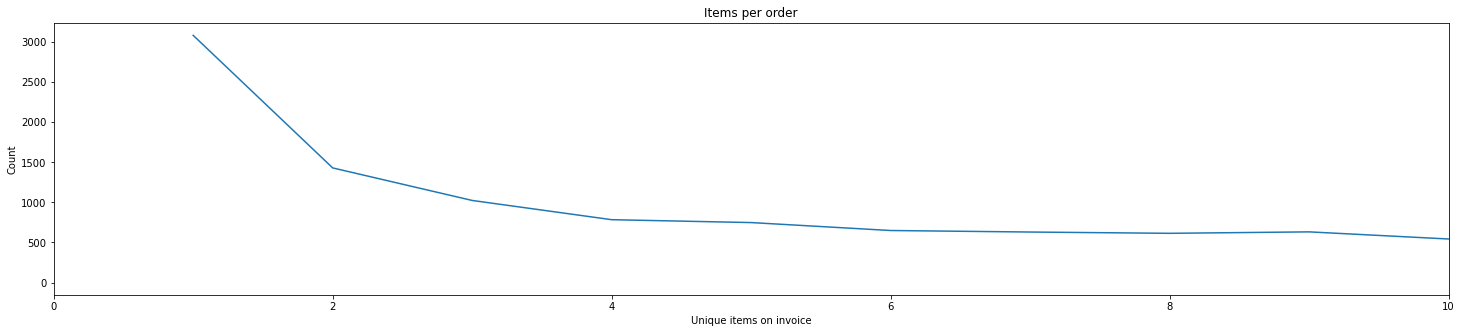

In [7]:
# Basic stats

grouped_by_invoiceno = df.groupby("InvoiceNo")

print("Items on invoice with most unique items:", df.groupby("InvoiceNo").size().max())
# axes = grouped_by_invoiceno.size().hist(bins=grouped_by_invoiceno.size().max()+1, figsize=(12, 4))
# axes = grouped_by_invoiceno.size().(bins=grouped_by_invoiceno.size().max()+1, figsize=(12, 4))
axes = df.groupby("InvoiceNo").size().value_counts().sort_index().plot.line(figsize=(25, 5), title="Items per order")
# display(axes.figure)
# axes = df.groupby("InvoiceNo").size().value_counts().sort_index()[0:100].plot.line(figsize=(25, 5))

# Interestingly, we have a few orders containing a great number of different products.
axes.set_xlabel('Unique items on invoice')
axes.set_ylabel('Count')
axes.set_xlim(0, 500)
display(axes.figure)
axes.set_xlim(0, 50)
display(axes.figure)
axes.set_xlim(0, 10)

# display(axes.figure)
# axes.set_xlim(0, 20)
# axes.set_ylim(0, 20)

print("")

Vi kan se ovenfor at langt det mest hyppige antal produkter per ordre er 1.
Til gengæld er der også en lang hale med ordrer med mange produkter.



Total number of orders: 21788
 - orders with 1 item: 3084
 - 14.2% of orders have only 1 item.
 - 25.4% of orders have 3 items or less.
 - 32.4% of orders have 5 items or less.
 - 46.5% of orders have 10 items or less.


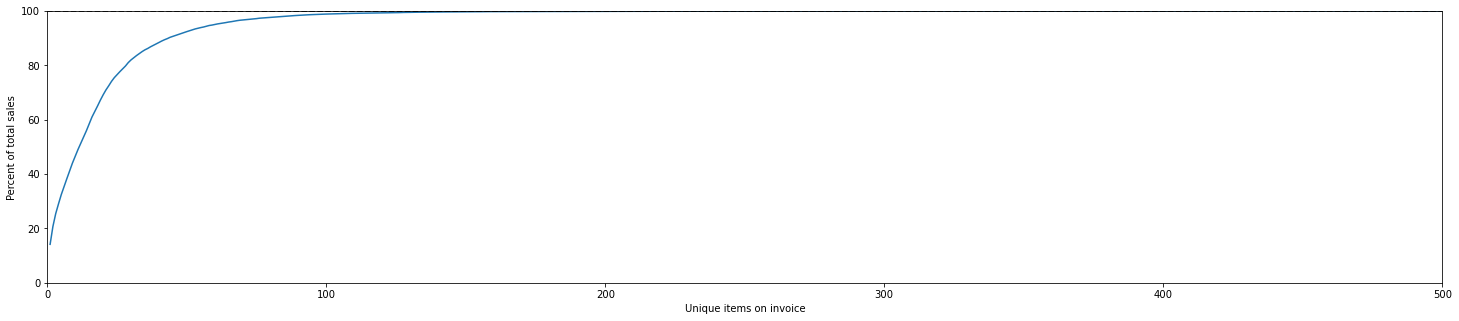

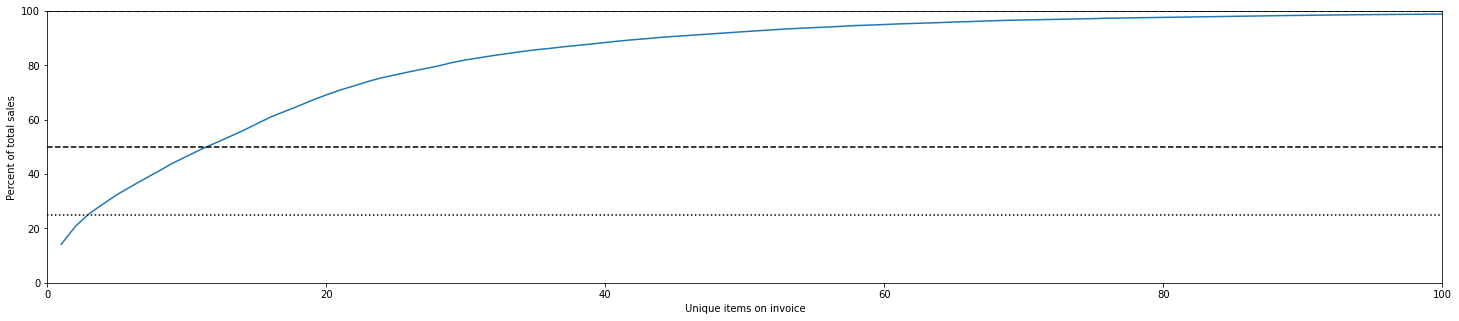

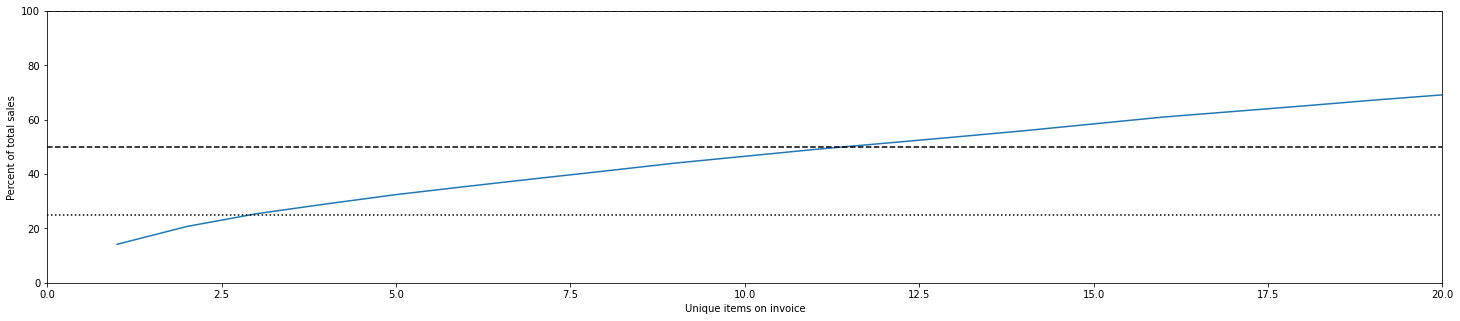

In [8]:
# axes = df.groupby("InvoiceNo").size().value_counts().sort_index()[0:20].plot.bar(figsize=(25, 5))
# order_sizes_cumsum = df.groupby("InvoiceNo").size().value_counts().sort_index().cumsum()
# Cumulative amount of the total:
order_sizes_cumsum = df.groupby("InvoiceNo").size().value_counts().sort_index().cumsum()
total_num_invoices = len(df.groupby("InvoiceNo"))  # Same as order_sizes_cumsum.max()
assert total_num_invoices == order_sizes_cumsum.max()
print(f"Total number of orders:", total_num_invoices)
print(f" - orders with 1 item:", order_sizes_cumsum[1])
print(f" - {100.*order_sizes_cumsum[1]/total_num_invoices:.1f}% of orders have only 1 item.")
print(f" - {100.*order_sizes_cumsum[3]/total_num_invoices:.1f}% of orders have 3 items or less.")
print(f" - {100.*order_sizes_cumsum[5]/total_num_invoices:.1f}% of orders have 5 items or less.")
print(f" - {100.*order_sizes_cumsum[10]/total_num_invoices:.1f}% of orders have 10 items or less.")


# CDF plots (Fraction in percent):
order_sizes_cdf = 100. * order_sizes_cumsum / order_sizes_cumsum.max()
axes = order_sizes_cdf.plot.line(figsize=(25, 5))
axes.axhline(100, linestyle="--", color="k")
axes.set_xlabel('Unique items on invoice')
axes.set_ylabel('Percent of total sales')
axes.set_xlim(0, 500)
axes.set_ylim(0, 100)
display(axes.figure)
axes.axhline([50], linestyle="--", color="k")
axes.axhline(25, linestyle=":", color="k")
axes.set_xlim(0, 100)
display(axes.figure)
axes.set_xlim(0, 20)
print("")


Den kummulative fordeling viser at 75% af alle bestillinger har over 3 unikke varer, og 50% af bestillinger har over 11 unikke varer. 14% af alle ordre har kun 1 vare.

Dvs:
* 25 % af bestillinger har 3 varer eller mindre.
* 14 % af bestillinger har kun 1 vare.

* ✅ Det er en relativt lille andel af det totale salg som har få forskellige varer i kurven.

* ✅ Størstedelen af ordre har mange varer.


### Which products are most popular?

* What products have been sold the most (most orders)?
* What products have been purchased by most users?


In [28]:

def build_products_df_from_sales(sales_df):
    # Først, lav en tabel med alle produkter.
    products_df = sales_df.groupby('StockCode').first()
    del products_df['InvoiceNo']
    del products_df['Quantity']
    del products_df['CustomerID']
    del products_df['Country']
    # Beregn product order count:
    # product_orders_count = df.groupby('StockCode')['InvoiceNo'].count().sort_values(ascending=False)
    product_orders_count = sales_df.groupby('StockCode').size()  # .size() same as ['InvoiceNo'].count()
    products_df['OrdersCount'] = product_orders_count

    # Beregn hvor mange brugere har købt hvert enkelt produkt:
    products_df['UsersCount'] = product_users_count = sales_df.groupby('StockCode')['CustomerID'].nunique()

    return products_df

products_df = build_products_df_from_sales(df)

# Sorter:
products_df_sorted = products_df.sort_values(by='OrdersCount', ascending=False)
# display(products_df_sorted)

print("Mest populære produkter (antal unikke ordre):")
with pd.option_context('display.max_rows', 100):
    display(products_df_sorted.head(100))


Mest populære produkter (antal unikke ordre):


,Description,InvoiceDate,UnitPrice,OrdersCount,UsersCount
StockCode,,,,,
85123A,WHITE HANGING HEART T-LIGHT HOLDER,12/1/2010 8:26,2.55,2077,858
22423,REGENCY CAKESTAND 3 TIER,12/1/2010 12:27,10.95,1905,887
85099B,JUMBO BAG RED RETROSPOT,12/1/2010 9:57,1.65,1662,636
84879,ASSORTED COLOUR BIRD ORNAMENT,12/1/2010 8:34,1.69,1418,679
47566,PARTY BUNTING,12/3/2010 12:43,4.65,1416,708
20725,LUNCH BAG RED RETROSPOT,12/1/2010 9:37,1.65,1359,532
22720,SET OF 3 CAKE TINS PANTRY DESIGN,12/13/2010 15:13,4.95,1232,640
20727,LUNCH BAG BLACK SKULL.,12/1/2010 11:29,1.65,1126,458
22197,SMALL POPCORN HOLDER,12/1/2010 10:19,0.72,1118,407


### Popularitet, baseret på antal ordre:

Fordeling af salg for alle 3676 produkter:


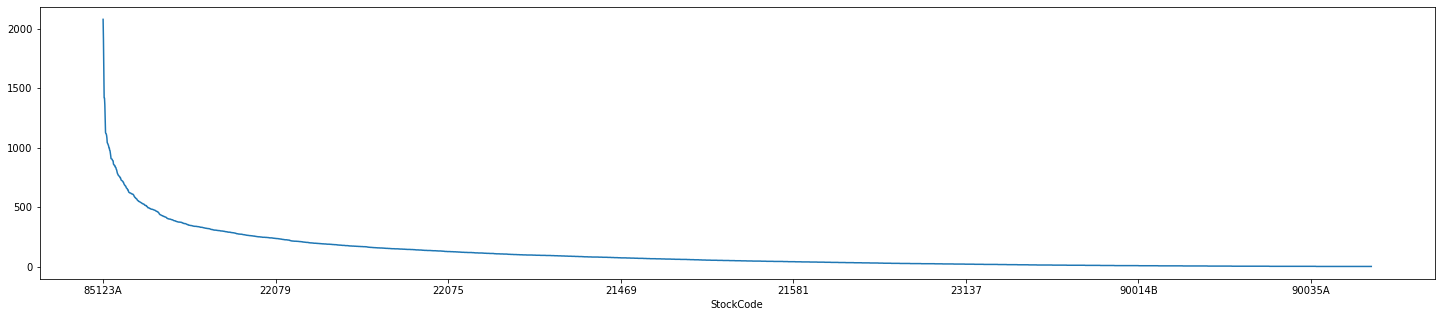

In [23]:
print(f"Fordeling af salg for alle {len(products_df_sorted)} produkter (sorteret):")
axsp = products_df_sorted['OrdersCount'].plot.line(figsize=(25, 5))

Popularitets bar-plot med antal ordre for de 100 mest populære produkter:


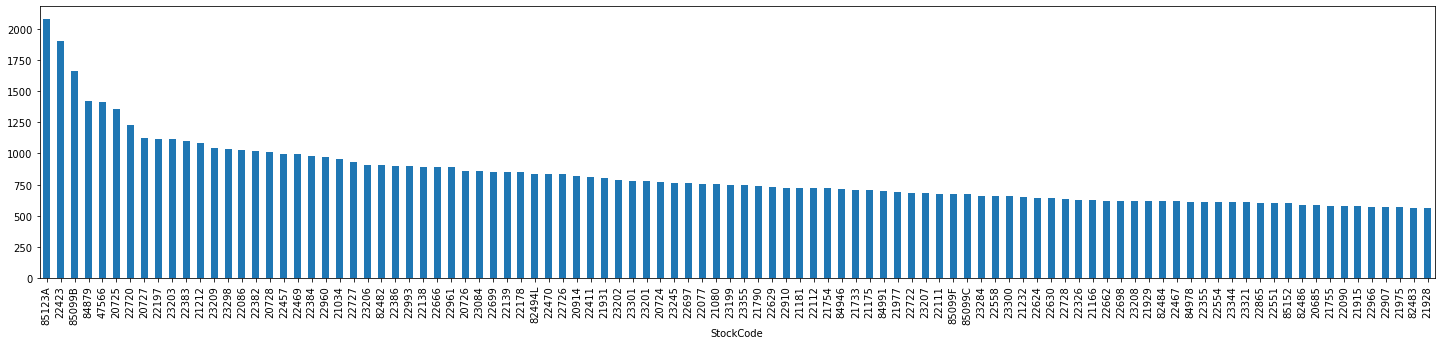

In [25]:
# Histogram med de 100 mest populære produkter:
print("Popularitets bar-plot med antal ordre for de 100 mest populære produkter:")
axsp = products_df_sorted['OrdersCount'][:100].plot.bar(figsize=(25, 5))
# axsp.figure

In [34]:
### Popularitet, baseret på antal kunder:

Fordeling af salg for alle 3676 produkter (sorteret):


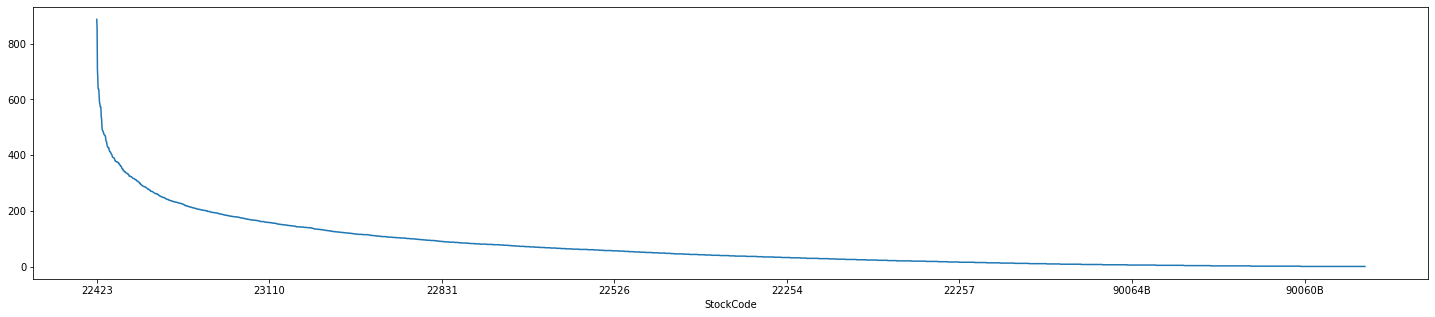

In [35]:
print(f"Fordeling af salg for alle {len(products_df_sorted)} produkter (sorteret):")
axsp = products_df_sorted['UsersCount'].sort_values(ascending=False).plot.line(figsize=(25, 5))

Popularitets bar-plot, baseret på hvor mange brugere har købt et produkt, for de 100 mest populære produkter:
(stadig sorteret )


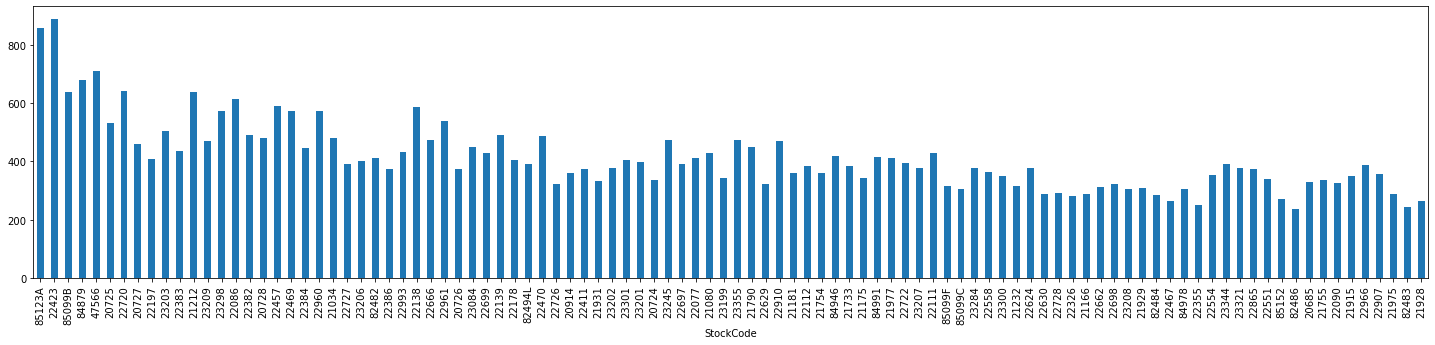

In [26]:
# Histogram med de 100 mest populære produkter, baseret på hvor mange brugere der har købt produktet:
print("Popularitets bar-plot, baseret på hvor mange brugere har købt et produkt, for de 100 mest populære produkter:")
print("(stadig sorteret )")
axsp = products_df_sorted['UsersCount'][:100].plot.bar(figsize=(25, 5))
# axsp.figure

### Cue: [Product Popularity Recommender](ProductPopularityRecommender.ipynb)


